# 0.0. Importação

In [1]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import requests

from IPython.display import Image

import datetime

from scipy import stats

In [2]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder

## 0.1. Funções auxiliares

In [3]:
def cramer_v(x, y):
    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = stats.chi2_contingency(cm)[0]
    chi2_corrected = chi2 - ((k - 1)*(r - 1))/(n - 1)
    k_corrected = k - ((k - 1)**2)/(n - 1)
    r_corrected = r - ((r - 1)**2)/(n - 1)
    
    return np.sqrt((chi2_corrected/n) / (min(k_corrected - 1, r_corrected - 1)))

## 0.2. Carregando os datasets

In [4]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge dataframes
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store' )

# 1.0. Descrição dos dados

In [6]:
# Original dataframe copy
df1 = df_raw.copy()

## 1.1. Rename columns

In [7]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [8]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

# Changing write pattern to snakecase

snakecase = lambda x: inflection.underscore( x )

cols_new = list( map( snakecase, cols_old ) )

# Renaming
df1.columns = cols_new

In [9]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimension

In [10]:
print( 'Number of rows: {}'.format(df1.shape[0]))
print( 'Number of rows: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of rows: 18


## 1.3. Data Types

In [11]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [12]:
df1['date'] = pd.to_datetime(df1['date'])

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4. Check NA

In [13]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [14]:
# First, we must analyze what every variable and data with NA values

# competition_distance
## Assumption: if it is NA, maybe it is because the store doesnt have an near competitor
## What has been done: CONSIDER AN EXTREME DISTANT RANGE FROM NEAR COMPETITOR

df1['competition_distance'].max()
df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 100000 if math.isnan(x) else x )

# competition_open_since_month
## Assumption: there are two main reasons that this data is NA: (i) the store doesnt have a near competitor or
## (ii) the store has an near competitor, but it the opening data is unknown, either it is older than the store or data is unavailable
## What has been done: CONSIDER THE SAME MONTH THAT THE STORE HAS BEEN OPEN (because it maybe older than the store)

# Error: EDIT Solved
df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
#Alternative: 
#df1.competition_open_since_month.fillna(df1.date.dt.month, inplace=True)

# competition_open_since_year
## Same ideia from variable above

#Error: EDIT: Solved
df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
#Alternative: 
#df1.competition_open_since_year.fillna(df1.date.dt.month, inplace=True)



# promo2
## Doesnt have any NA

# promo2_since_week
## Assumption: it is possible that the NA values are due to lack of participation/extension of any promotions.
## What I think should have been done: ALL NA VALUES ARE CONSIDERED "0", AS THE STORE IS NOT EXTENDING PROMOTIONS
## What has actually been done: CONSIDER THE SAME VALUE AS THE DATE
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].month if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)


# promo2_since_year
## Same logic as above
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)


# promo_interval
## The problem here is that, it is hard to understand the way it has been inserted.
## What has been done: (i) Analyze the interval of the promo; (ii) Check if sale month is in promo_interval
## if it is, (iii) apply value 1 to new column is_promo, else 0.
## This way, it will be easy to check if sale is inside a promotion interval.

month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec', }

df1['promo_interval'].fillna(0, inplace=True)
df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1 )

df1.isna().sum()


store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

In [15]:
df1.sample(5).T

,748968,597469,653847,51353,290395
store,474,615,128,64,864
day_of_week,4,7,5,1,2
date,2013-08-29 00:00:00,2014-01-12 00:00:00,2013-11-22 00:00:00,2015-06-15 00:00:00,2014-11-04 00:00:00
sales,8496,0,7750,14607,6116
customers,799,0,612,956,721
open,1,0,1,1,1
promo,1,0,1,1,1
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,c,d,d,d,a


## 1.6. Change Types

In [16]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [17]:
# Competion and promos since are portrayed as float types, while it should be int type.

df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistical

In [18]:
num_attributes = df1.select_dtypes( include=['int64','float64'])
cat_attributes = df1.select_dtypes( exclude=['int64','float64', 'datetime64[ns]'])

num_attributes.sample(5)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
979602,303,7,0,0,0,0,0,15430.0,11,2012,1,18,2011,0
71469,110,4,4414,552,1,0,0,46590.0,4,2013,0,5,2015,0
26846,87,2,6043,780,1,0,0,560.0,12,2010,0,7,2015,0
150278,869,4,6644,913,1,1,0,230.0,10,2001,1,14,2011,0
991440,991,4,6223,594,1,1,0,1010.0,1,2013,0,1,2013,0


### 1.7.1. Numerical Attributes

In [19]:
# Central tendency - mean, median

ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - std, min, max, range, skew, kurtosis

d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate

n = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
                  
n.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

n

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,100000.0,99980.0,5675.712376,2330.0,9085.159292,4.637208,35.287543
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


/home/pedro/.pyenv/versions/3.8.0/envs/DataScienceEmProducao/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

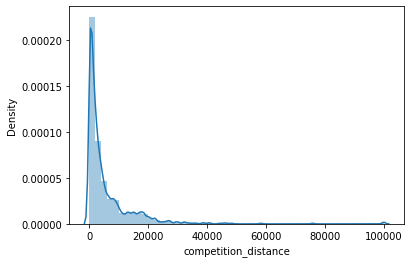

In [20]:
sns.distplot( df1['competition_distance'] )

### 1.7.2. Categorical Attributes

In [21]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='state_holiday', ylabel='sales'>

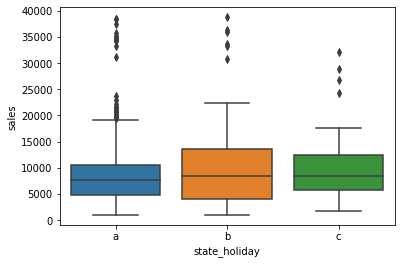

In [22]:
filter1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]
sns.boxplot(x='state_holiday', y='sales', data=filter1)

<AxesSubplot:xlabel='assortment', ylabel='sales'>

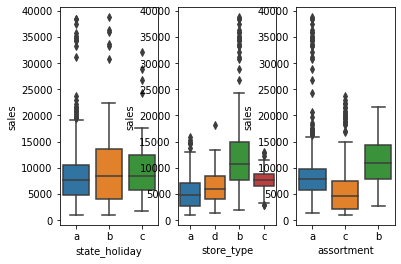

In [23]:
plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=filter1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=filter1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=filter1)

# 2.0. FEATURE ENGINEERING

In [24]:
df2 = df1.copy()

df2.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo
394363,1077,3,2014-07-16,5155,529,1,1,0,1,a,a,3750.0,11,2001,1,35,2010,"Mar,Jun,Sept,Dec",Jul,0
593943,434,3,2014-01-15,6904,571,1,0,0,0,a,a,13020.0,8,2003,1,40,2014,"Jan,Apr,Jul,Oct",Jan,1
289900,273,2,2014-11-04,10097,886,1,1,0,0,a,c,8480.0,11,2014,0,11,2014,0,Nov,0
310119,968,2,2014-10-14,6804,864,1,0,0,0,c,a,1190.0,10,2014,0,10,2014,0,Oct,0
553290,1036,5,2014-02-21,5196,532,1,1,0,0,d,c,9560.0,2,2014,1,36,2013,"Jan,Apr,Jul,Oct",Fev,0


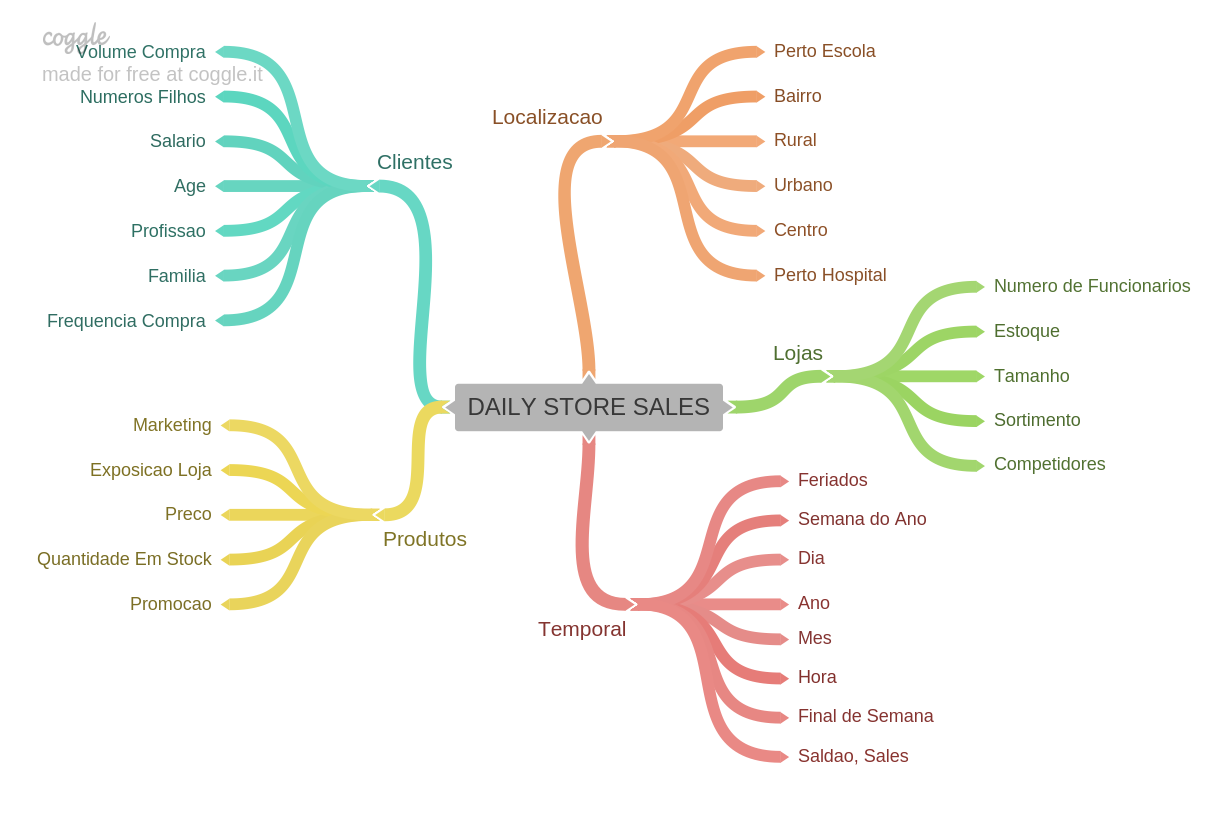

In [25]:
Image('img/MindMapHypothesis.png')

## 2.1. Hypothesis mental map

### 2.1.1. Stores Hypothesis

**1.** Stores with more employees **should** have more sales

**2.** Stores with more product stock **should** have more sales

**3.** Smaller stores **should** have less sales

**4.** Bigger stores **should** have more sales

**5.** Stores with more product options **should** have more sales

### 2.1.2. Product Hypothesis

**1.** Stores with more marketing investment **should** have more sales

**2.** Stores that exposes more the products **should** sell more those products

**3.** Stores with smaller product prices **should** have more sales of those products

**4.** Stores with smaller product prices for the longest possible time **should** have more sales

### 2.1.3. Time Hypothesis

**1.** Stores with more holidays **should** have less sales

**2.** Stores that opens at the first 6 months **should** have more sales

**3.** Stores that opens at the weekends **should** have more sales

## 2.2. Hypothesis priorization

The hypothesis that should have prioritized are the ones with the data available at the start of the proccess

**1.** Stores with more product options **should** have more sales

**2.** Stores with closer competitors **should** have less sales

**3.** Stores with competitors open for the longest time **should** have more sales


**4.** Stores with more active promotions **should** have more sales

**5.** Stores with more promotion days **should** have more sales

**6.** Stores with consecutive promotions **should** have more sales


**7.** Stores open at Xmas **should** have more sales

**8.** Stores sales **should** grow through the years

**9.** Stores **should** sell more at the second half of the year

**10.** Stores **should** sell more after the tenth day of each month

**11.** Stores **should** sell less at the weekends

**12.** Stores **should** sell less at school holydays

## 2.3 Feature Engineering

In [26]:
#year
df2['year'] = df2['date'].dt.year

#month
df2['month'] = df2['date'].dt.month

#day
df2['day'] = df2['date'].dt.day

#weekofyear
df2['week_of_year'] = df2['date'].dt.weekofyear

#year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

#competitionsince
df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1 )
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

#promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7) )
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days ).astype(int)

#assortment
df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

#state holiday
df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

<ipython-input-26-3a0c7f06c309>:11: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df2['week_of_year'] = df2['date'].dt.weekofyear


In [27]:
df2.sample(5).T

,474828,526938,660854,889171,5060
store,624,329,445,187,601
day_of_week,5,7,6,4,1
date,2014-05-02 00:00:00,2014-03-16 00:00:00,2013-11-16 00:00:00,2013-04-25 00:00:00,2015-07-27 00:00:00
sales,10395,0,11545,5553,7173
customers,981,0,1772,756,433
open,1,0,1,1,1
promo,1,0,0,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,0,0,0,0,1
store_type,a,a,a,a,d


# 3.0. VARIABLE FILTERING

In [28]:
df3 = df2.copy()

## 3.1. Line Filtering

In [29]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Column FIltering

In [30]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

df3 = df3.drop(cols_drop, axis = 1)

# 4.0. EXPLORATORY DATA ANALYSIS

In [31]:
df4 = df3.copy()

## 4.1. Univariate Analysis

### 4.1.1. Response Variable

/home/pedro/.pyenv/versions/3.8.0/envs/DataScienceEmProducao/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

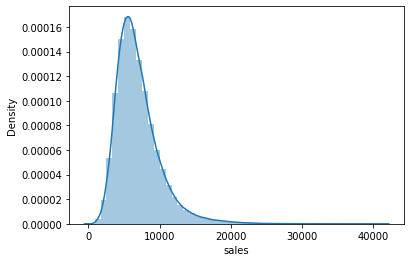

In [32]:
sns.distplot(df4['sales'])

# The more the graph seems like a bell curve, the better.
# It is because some models and algorithms are based on normal shape curve
# Applying functions such as log makes the graph looks more like the bell.

### 4.1.2. Numerical Variable

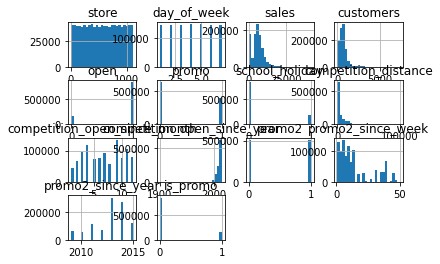

In [33]:
num_attributes.hist(bins=25)

plt.show()

### 4.1.3 Categorical Variable

In [34]:
cat_attributes.sample(5)

,state_holiday,store_type,assortment,promo_interval,month_map
853812,0,a,c,"Jan,Apr,Jul,Oct",May
510720,0,a,a,0,Mar
888072,0,c,c,0,Apr
343619,0,c,c,"Jan,Apr,Jul,Oct",Sep
948842,0,d,c,0,Mar


/home/pedro/.pyenv/versions/3.8.0/envs/DataScienceEmProducao/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/pedro/.pyenv/versions/3.8.0/envs/DataScienceEmProducao/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/pedro/.pyenv/versions/3.8.0/envs/DataScienceEmProducao/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing 

<AxesSubplot:xlabel='sales', ylabel='Density'>

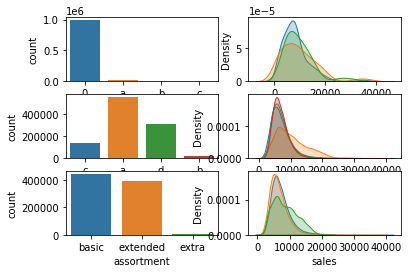

In [35]:


# State holiday
plt.subplot(3, 2, 1)
#a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(cat_attributes['state_holiday'])

plt.subplot(3, 2, 2)
sns.kdeplot( df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot( df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

# Store type
plt.subplot(3, 2, 3)
sns.countplot(cat_attributes['store_type'])

plt.subplot(3, 2, 4)
sns.kdeplot( df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot( df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

# Assortment
plt.subplot(3, 2, 5)
sns.countplot(df4['assortment'])

plt.subplot(3, 2, 6)
sns.kdeplot( df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot( df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)





## 4.2. Bivariate Analysis

### Hypothesis **1.** Stores with more product options **should** have more sales

<AxesSubplot:xlabel='year_week'>

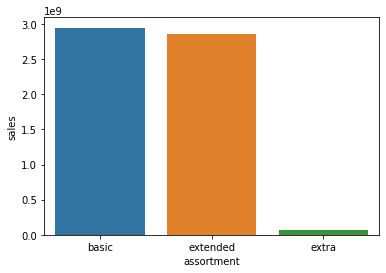

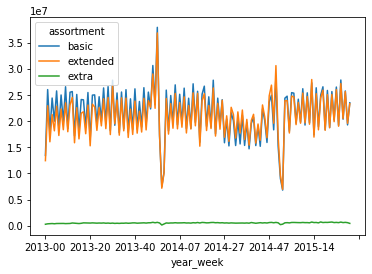

In [36]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment', y='sales', data= aux1);

aux2 = df4[['year_week','assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()
#sns.barplot(x='assortment', y='sales', data= aux2);

**False** Results shows that the basic assortment store type, sells **more** than a store with more assortment

### Hypothesis **2.** Stores with closer competitors **should** have less sales

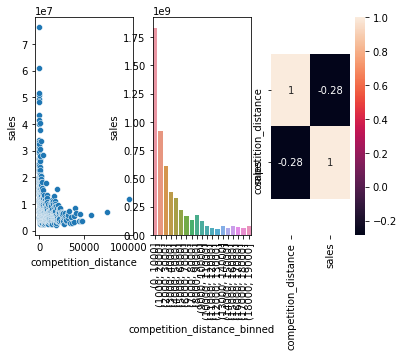

In [37]:
aux1 = df4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.subplot (1, 3, 1)
bins = list(np.arange(0, 20000, 1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
#sns.barplot(x='competition_distance_binned', y='sales', data= aux1);
sns.scatterplot(x='competition_distance', y='sales', data=aux1)

plt.subplot(1, 3, 2)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
sns.barplot(x='competition_distance_binned', y='sales', data= aux2);
plt.xticks(rotation=90)

plt.subplot(1, 3, 3)
x = sns.heatmap(aux1.corr(method='pearson'), annot=True)
bottom, top = x.get_ylim()
x.set_ylim(bottom+0.5, top-0.5);

**False** Stores with closer competitors actually sells **more** than stores with distant competitors

### Hypothesis **3.** Stores with competitors open for the longest time **should** have more sales

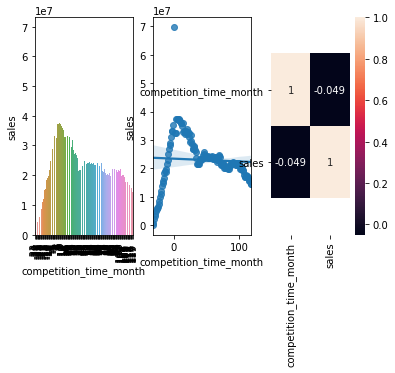

In [38]:
plt.subplot(1, 3, 1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux4 = aux1[(aux1['competition_time_month'] < 120 ) & (aux1['competition_time_month'] != 0) ]
sns.barplot(x='competition_time_month', y='sales', data=aux4)
plt.xticks(rotation=90);

plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=aux4)

plt.subplot(1, 3, 3)
x = sns.heatmap(aux4.corr(method='pearson'), annot=True)
bottom, top = x.get_ylim()
x.set_ylim(bottom+0.5, top-0.5);

**False** stores with longer competition sells **less**. However, the behavior of sales is different before competition starts and after it starts.

## 4.3. Multivariate Analysis

### 4.3.1. Numerical Attributes

<AxesSubplot:>

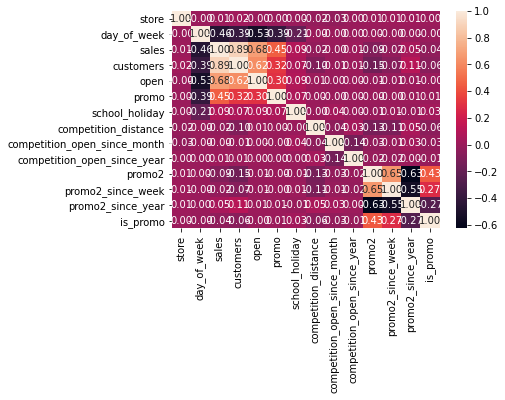

In [39]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True, fmt='.2f')

### 4.3.2. Categorical Attributes

In [40]:
from scipy import stats

categorical = df4.select_dtypes(include='object')
categorical.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


In [41]:
cm = pd.crosstab(categorical['state_holiday'], categorical['store_type']).values

In [42]:
a1 = cramer_v(categorical['state_holiday'], categorical['state_holiday'])
a2 = cramer_v(categorical['state_holiday'], categorical['store_type'])
a3 = cramer_v(categorical['state_holiday'], categorical['assortment'])

a4 = cramer_v(categorical['store_type'], categorical['state_holiday'])
a5 = cramer_v(categorical['store_type'], categorical['store_type'])
a6 = cramer_v(categorical['store_type'], categorical['assortment'])

a7 = cramer_v(categorical['assortment'], categorical['state_holiday'])
a8 = cramer_v(categorical['assortment'], categorical['store_type'])
a9 = cramer_v(categorical['assortment'], categorical['assortment'])

d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9] })

In [43]:
d = d.set_index(d.columns)
d.head()

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


<AxesSubplot:>

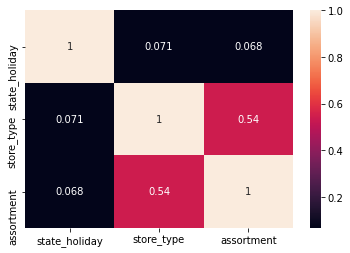

In [44]:
sns.heatmap(d, annot=True)

# 5.0. DATA PREPARATION

In [45]:
df5 = df4.copy()

## 5.1. Data normalization

## 5.2. Data rescaling

In [46]:
a = df5.select_dtypes(include=['int64','float64'])

In [47]:
# Before choosing which rescale method will be used, we must know which variables have outliers.
#sns.boxplot(df5['competition_distance'])
import pickle

# competition distance
rs = RobustScaler()
df5['competition_distance'] = rs.fit_transform( df5[['competition_distance']].values )
pickle.dump(rs, open('parameters/competition_distance_scaler.pkl','wb'))

# competition time month
mms = MinMaxScaler()
df5['competition_time_month'] = mms.fit_transform( df5[['competition_time_month']].values )
pickle.dump(mms, open('parameters/time_month_scaler.pkl','wb'))

# year
df5['year'] = mms.fit_transform( df5[['year']].values )
pickle.dump(mms, open('parameters/year_scaler.pkl','wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform( df5[['promo_time_week']].values )
pickle.dump(mms, open('parameters/promo_time_week_scaler.pkl','wb'))

#sns.distplot(df5['competition_distance'])

## 5.3. Data transformation

### 5.3.1. Encoding

In [48]:
#df5.select_dtypes('object')

# state holiday - One hot encoding
df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])
df5.head()


,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,c,basic,-0.170968,9,...,31,2015-30,2008-09-01,0.080612,2015-02-09,0.341686,0,0,0,1
1,2,5,2015-07-31,6064,1,1,a,basic,-0.283871,11,...,31,2015-30,2007-11-01,0.087561,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,a,basic,1.903226,12,...,31,2015-30,2006-12-01,0.095205,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,c,extended,-0.275806,9,...,31,2015-30,2009-09-01,0.071577,2015-02-09,0.341686,0,0,0,1
4,5,5,2015-07-31,4822,1,1,a,basic,4.448387,4,...,31,2015-30,2015-04-01,0.025017,2015-02-09,0.341686,0,0,0,1


In [49]:
# store type - Label Encoder
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('parameters/enconding_store_type.pkl','wb'))

# assortment - Ordinal Encoder
assortment_dict = {'basic':1, 'extra':2, 'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,...,31,2015-30,2008-09-01,0.080612,2015-02-09,0.341686,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,...,31,2015-30,2007-11-01,0.087561,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,...,31,2015-30,2006-12-01,0.095205,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,...,31,2015-30,2009-09-01,0.071577,2015-02-09,0.341686,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,...,31,2015-30,2015-04-01,0.025017,2015-02-09,0.341686,0,0,0,1


### 5.3.2. Response Variable Transformation

In [50]:
df5['sales'] = np.log1p( df5['sales'])

/home/pedro/.pyenv/versions/3.8.0/envs/DataScienceEmProducao/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

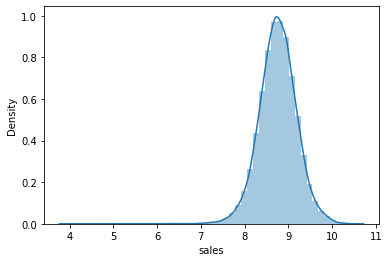

In [51]:
sns.distplot(df5['sales'])

### 5.3.1. Nature Transformation

In [52]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * (2 * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * (2 * np.pi/7)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * (2 * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * (2 * np.pi/30)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * (2 * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * (2 * np.pi/12)))

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * (2 * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * (2 * np.pi/52)))


# 6.0. FEATURE SELECTION

In [53]:
df6 = df5.copy()

## 6.1. Split dataframe

In [54]:
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']

df6 = df6.drop(cols_drop, axis=1)

In [55]:
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

In [56]:
# training dataset
x_train = df6[df6['date'] < '2015-06-19']
y_train = x_train['sales']

# test dataset
x_test = df6[df6['date'] >= '2015-06-19']
y_test = x_test['sales']

print('Training min Date: {}'.format(x_train['date'].min()))
print('Training max Date: {}'.format(x_train['date'].max()))

print('Test min Date: {}'.format(x_test['date'].min()))
print('Test max Date: {}'.format(x_test['date'].max()))

Training min Date: 2013-01-01 00:00:00
Training max Date: 2015-06-18 00:00:00
Test min Date: 2015-06-19 00:00:00
Test max Date: 2015-07-31 00:00:00


## 6.2. Boruta as Feature Selector

In [57]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

In [58]:
# training and test dataset for Boruta
x_train_n = x_train.drop(['date','sales'], axis=1).values
y_train_n = y_train.values.ravel()


# define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)

# define Boruta
#boruta = BorutaPy(rf, n_estimators='auto',verbose=2,random_state=42).fit(x_train_n,y_train_n)

### 6.2.1. Best features from Boruta

In [59]:
#cols_selected = boruta.support_.tolist()

# best features
#x_train_fs = x_train.drop(['date', 'sales'], axis=1)
#cols_selected_boruta = x_train_fs.iloc[:, cols_selected].columns.to_list()

# not selected boruta
#cols_not_selected_boruta = list(np.setdiff1d( x_train_fs.columns, cols_selected_boruta))

### 6.3. Manual Feature Selection

In [60]:
cols_selected_boruta = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'day_sin',
                        'day_cos',
                        'month_cos',
                        'month_sin',
                        'week_of_year_cos',
                        'week_of_year_sin']

# month_sin and week_of_year_sin added manually. All other variables were defined by boruta.

# columns to add
feat_to_add = ['date','sales']

# final features
#cols_selected_boruta.extend(feat_to_add)

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)

# 7. Machine Learning Algos

In [61]:
X_train = x_train[cols_selected_boruta]
X_test = x_test[cols_selected_boruta]

## 7.1. Average model

In [62]:
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [63]:
def mean_absolute_percentage_error(y, yhat):
    
    return np.mean(np.abs((y - yhat) / y ))

def ml_error(model_name, y, yhat):
    
    mae = mean_absolute_error(y, yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error(y, yhat))
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse }, index=[0])

In [64]:
aux1 = X_test.copy()
aux1['sales'] = y_test.copy()

aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')

yhat_baseline = aux1['predictions']

# Performance
baseline_error = ml_error('Average_Model', np.expm1(y_test), np.expm1(yhat_baseline) )

baseline_error

,Model Name,MAE,MAPE,RMSE
0,Average_Model,1354.800353,0.455051,1835.135542


## 7.2. Linear Regression 

In [65]:
from sklearn.linear_model import LinearRegression, Lasso

In [66]:
#model
lr = LinearRegression().fit(X_train, y_train)

# prediction

yhat_lr = lr.predict(X_test)

# performance
lr_error = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr) )
lr_error

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1872.265525,0.295371,2666.035764


## 7.3. Linear Regression Regularized (LASSO)

In [67]:
#model
lrr = Lasso(alpha=0.001).fit(X_train, y_train)

# prediction

yhat_lrr = lrr.predict(X_test)

# performance
lrr_error = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lrr) )
lrr_error

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1873.163753,0.288561,2696.356099


Comparison between models shows that linear models performed worse than the average model. Thus, the problem requires models that can deal with complex or non-linear probleams in order to solve the problem with good accuracy.

## 7.4. Random Forest Regressor

In [68]:
#model
#rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(X_train, y_train)

# prediction

#yhat_rf = rf.predict(X_test)

# performance
#rf_error = ml_error('Random Forest', np.expm1(y_test), np.expm1(yhat_rf) )
#rf_error

## 7.5. XGBoost Regressor

In [69]:
import xgboost as xgb

In [70]:
#model
model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytee=0.9,
                             n_jobs=-1, random_state=42).fit(X_train, y_train)

# prediction

yhat_xgb = model_xgb.predict(X_test)

# performance
xgb_error = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb) )
xgb_error

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,855.48815,0.125801,1252.330206


## 7.6. Cross-time validation

In [71]:
x_training = x_train[cols_selected_boruta_full]

In [72]:
#k = 1

def cross_validation(x_training, kfold, model_name, model):

    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1,kfold+1)):

        print('KFold: {}'.format(k))

        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training
        ytraining = training['sales']
        xtraining = training.drop(['date','sales'], axis=1)

        # validation
        yvalidation = validation['sales']
        xvalidation = validation.drop(['date','sales'], axis=1)

        # model
        m = model.fit(xtraining,ytraining)

        #prediction
        yhat = m.predict(xvalidation)
        #print(validation.head())
        # performance
        error = ml_error('Linear Regression', np.expm1(yvalidation), np.expm1(yhat))

        mae_list.append(error['MAE'])
        mape_list.append(error['MAPE'])
        rmse_list.append(error['RMSE'])

        print('Validation start date: {}'.format(validation_start_date))    
        print('Validation end date:   {}'.format(validation_end_date)) 

    return pd.DataFrame({'Model name': model_name,
                         'MAE CV': np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
                         'MAPE CV': np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
                         'RMSE CV': np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)
                         }, index=[0])





### 7.6.1. Linear Regression Model - validation

In [73]:
lr_validation = cross_validation(x_training, 5, 'Linear regression', LinearRegression())
lr_validation

KFold: 5
Validation start date: 2014-11-20 00:00:00
Validation end date:   2015-01-01 00:00:00
KFold: 4
Validation start date: 2015-01-01 00:00:00
Validation end date:   2015-02-12 00:00:00
KFold: 3
Validation start date: 2015-02-12 00:00:00
Validation end date:   2015-03-26 00:00:00
KFold: 2
Validation start date: 2015-03-26 00:00:00
Validation end date:   2015-05-07 00:00:00
KFold: 1
Validation start date: 2015-05-07 00:00:00
Validation end date:   2015-06-18 00:00:00


,Model name,MAE CV,MAPE CV,RMSE CV
0,Linear regression,2094.79 +/- 301.94,0.3 +/- 0.02,2960.98 +/- 486.59


### 7.6.2. Linear Regression Regularized model - validation

In [74]:
lasso_validation = cross_validation(x_training, 5, 'LASSO', Lasso(alpha=0.001))
lasso_validation

KFold: 5
Validation start date: 2014-11-20 00:00:00
Validation end date:   2015-01-01 00:00:00
KFold: 4
Validation start date: 2015-01-01 00:00:00
Validation end date:   2015-02-12 00:00:00
KFold: 3
Validation start date: 2015-02-12 00:00:00
Validation end date:   2015-03-26 00:00:00
KFold: 2
Validation start date: 2015-03-26 00:00:00
Validation end date:   2015-05-07 00:00:00
KFold: 1
Validation start date: 2015-05-07 00:00:00
Validation end date:   2015-06-18 00:00:00


,Model name,MAE CV,MAPE CV,RMSE CV
0,LASSO,2102.23 +/- 340.97,0.3 +/- 0.02,3003.5 +/- 525.39


### 7.6.3. Random Forest model - validation

In [75]:
#model_random_forest = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
#random_forest_validation = cross_validation(x_training, 5, 'Random Forest', model_random_forest)
#random_forest_validation

### 7.6.4. XGBoost model - validation

In [76]:
xgboost_model = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=100,
                             eta=0.01,
                             max_depth=10,
                             subsample=0.7,
                             colsample_bytee=0.9,
                             n_jobs=-1, random_state=42)

xgboost_validation = cross_validation(x_training, 5, 'XGBoost model', xgboost_model)
xgboost_validation

KFold: 5
Validation start date: 2014-11-20 00:00:00
Validation end date:   2015-01-01 00:00:00
KFold: 4
Validation start date: 2015-01-01 00:00:00
Validation end date:   2015-02-12 00:00:00
KFold: 3
Validation start date: 2015-02-12 00:00:00
Validation end date:   2015-03-26 00:00:00
KFold: 2
Validation start date: 2015-03-26 00:00:00
Validation end date:   2015-05-07 00:00:00
KFold: 1
Validation start date: 2015-05-07 00:00:00
Validation end date:   2015-06-18 00:00:00


,Model name,MAE CV,MAPE CV,RMSE CV
0,XGBoost model,1026.55 +/- 165.92,0.14 +/- 0.02,1471.11 +/- 224.31


## 7.7. Compare model's performance

In [77]:
#model_results = pd.concat([lr_validation, lasso_validation, random_forest_validation, xgboost_validation])
#model_results

# 8. Fine Tuning

## 8.1. Random Search

In [78]:
import random
import warnings
warnings.filterwarnings('ignore')


param = {'n_estimators':[150, 170, 250, 300, 350],
         'eta':[0.01, 0.03],
         'max_depth':[3, 5, 9],
         'subsample':[0.1, 0.5, 0.7],
         'colsample_bytee':[0.3, 0.7, 0.9],
         'min_child_weight':[3, 8, 15]
        }

MAX_EVAL = 5

In [79]:
#model

#final_result = pd.DataFrame()

#for i in range(MAX_EVAL):
    
#    hp = { k: random.sample(v,1)[0] for k, v in param.items()}
    
#    print(hp)

#    model_xgb = xgb.XGBRegressor(objective='reg:squarederror',
                                 n_estimators=hp['n_estimators'],
                                 eta=hp['eta'],
                                 max_depth=hp['max_depth'],
                                 subsample=hp['subsample'],
                                 colsample_bytee=hp['colsample_bytee'],
                                 min_child_weight=hp['min_child_weight'],
                                 n_jobs=-1, random_state=42)


    # performance
#    result = cross_validation(x_training, 5, 'XGBoost model', model_xgb)
#    final_result = pd.concat([final_result, result])
    
#final_result

IndentationError: unexpected indent (<ipython-input-79-242a3617f453>, line 12)

## 8.2. Final model

In [80]:
param_tuned = {'n_estimators':350,
         'eta':0.03,
         'max_depth':9,
         'subsample':0.5,
         'colsample_bytee':0.3,
         'min_child_weight':3
        }

In [81]:
model_xgb_tuned = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=param_tuned['n_estimators'],
                             eta=param_tuned['eta'],
                             max_depth=param_tuned['max_depth'],
                             subsample=param_tuned['subsample'],
                             colsample_bytee=param_tuned['colsample_bytee'],
                             min_child_weight=param_tuned['min_child_weight'],
                             n_jobs=-1, random_state=42).fit(X_train, y_train)


                            
# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(X_test)

# performance
xgb_error_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned) )
xgb_error_tuned


,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,682.429921,0.099102,996.569818


# 9. Model error interpretation

In [82]:
df9 = x_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1. Business performance

In [83]:
# sum of predictions

df9_1 = df9[['store','predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store', 'sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAE'})
df9_aux2 = df9[['store', 'sales','predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'],x['predictions'])).reset_index().rename(columns={0:'MAPE'})

df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner',on='store')
df9_2 = pd.merge(df9_1,df9_aux3, how='inner',on='store')

# scenarios
df9_2['worst_scenario'] = df9_2['predictions'] - df9_2['MAE']
df9_2['best_scenario'] = df9_2['predictions'] + df9_2['MAE']

# ordering columns

df9_2 = df9_2[['store','predictions','worst_scenario','best_scenario','MAE','MAPE']]

df9_2.head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
0,1,162539.640625,162262.794994,162816.486256,276.845631,0.062923
1,2,178859.718750,178513.140064,179206.297436,346.578686,0.070781
2,3,257604.140625,257065.035414,258143.245836,539.105211,0.076125
3,4,334714.937500,333679.415079,335750.459921,1035.522421,0.098984
4,5,177110.328125,176589.503576,177631.152674,520.824549,0.115673


## 9.2. Total performance

In [84]:
df9_3 = df9_2[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index':'Scenarios', 0:'Values'})

df9_3['Values'] = df9_3['Values'].map('R${:,.2f}'.format)

df9_3.head()

,Scenarios,Values
0,predictions,"R$283,575,008.00"
1,worst_scenario,"R$282,810,204.50"
2,best_scenario,"R$284,339,837.69"


## 9.3. Machine Learning Performance

In [85]:
df9['errors'] = df9['predictions'] - df9['sales']
df9['error_rate'] = df9['predictions'] / df9['sales']                                       

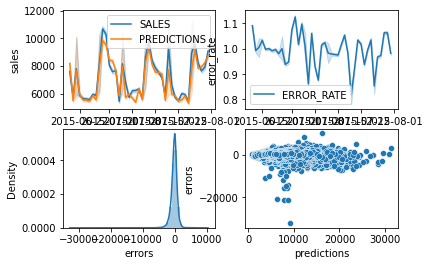

In [86]:
plt.subplot(2,2,1)
sns.lineplot(x='date',y='sales', data=df9, label='SALES')
sns.lineplot(x='date',y='predictions', data=df9, label='PREDICTIONS')

plt.subplot(2,2,2)
sns.lineplot(x='date',y='error_rate', data=df9, label='ERROR_RATE')

plt.subplot(2,2,3)
sns.distplot(df9['errors'])


plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'], df9['errors'])

plt.show()

# 10. Deploying model to production

In [87]:
pickle.dump(model_xgb_tuned, open('model/model_xgb_tuned.pkl','wb'))

## 10.1. Rossman Class

In [88]:
import pickle
import inflection
import pandas as pd
import numpy as np
import math
import datetime


class Rossman(object):
    
    def __init__(self):
        
        self.home_path = '/home/pedro/Documentos/repositories/1-Rossman-Sales-Prediction'
        self.competition_distance_scaler = pickle.load(open(self.home_path + 'parameters/competition_distance_scaler.pkl','rb'))
        self.time_month_scaler           = pickle.load(open(self.home_path + 'parameters/time_month_scaler.pkl','rb'))
        self.year_scaler                 = pickle.load(open(self.home_path + 'parameters/year_scaler.pkl','rb'))
        self.promo_time_week_scaler      = pickle.load(open(self.home_path + 'parameters/promo_time_week_scaler.pkl','rb'))
        self_encoding_store_type         = pickle.load(open(self.home_path + 'parameters/enconding_store_type.pkl','rb'))        

            
    def data_cleaning(self,df1):

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
                   'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
                   'CompetitionDistance', 'CompetitionOpenSinceMonth',
                   'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                   'Promo2SinceYear', 'PromoInterval']

        # Changing write pattern to snakecase

        snakecase = lambda x: inflection.underscore( x )

        cols_new = list( map( snakecase, cols_old ) )

        # Renaming
        df1.columns = cols_new

        ## 1.3. Data Types

        df1['date'] = pd.to_datetime(df1['date'])

        ## 1.5. Fillout NA

        # First, we must analyze what every variable and data with NA values

        # competition_distance
        ## Assumption: if it is NA, maybe it is because the store doesnt have an near competitor
        ## What has been done: CONSIDER AN EXTREME DISTANT RANGE FROM NEAR COMPETITOR

        df1['competition_distance'] = df1['competition_distance'].apply( lambda x: 100000 if math.isnan(x) else x )

        # competition_open_since_month
        ## Assumption: there are two main reasons that this data is NA: (i) the store doesnt have a near competitor or
        ## (ii) the store has an near competitor, but it the opening data is unknown, either it is older than the store or data is unavailable
        ## What has been done: CONSIDER THE SAME MONTH THAT THE STORE HAS BEEN OPEN (because it maybe older than the store)

        # Error: EDIT Solved
        df1['competition_open_since_month'] = df1.apply( lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)
        #Alternative: 
        #df1.competition_open_since_month.fillna(df1.date.dt.month, inplace=True)

        # competition_open_since_year
        ## Same ideia from variable above

        #Error: EDIT: Solved
        df1['competition_open_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
        #Alternative: 
        #df1.competition_open_since_year.fillna(df1.date.dt.month, inplace=True)



        # promo2
        ## Doesnt have any NA

        # promo2_since_week
        ## Assumption: it is possible that the NA values are due to lack of participation/extension of any promotions.
        ## What I think should have been done: ALL NA VALUES ARE CONSIDERED "0", AS THE STORE IS NOT EXTENDING PROMOTIONS
        ## What has actually been done: CONSIDER THE SAME VALUE AS THE DATE
        df1['promo2_since_week'] = df1.apply( lambda x: x['date'].month if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)


        # promo2_since_year
        ## Same logic as above
        df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)


        # promo_interval
        ## The problem here is that, it is hard to understand the way it has been inserted.
        ## What has been done: (i) Analyze the interval of the promo; (ii) Check if sale month is in promo_interval
        ## if it is, (iii) apply value 1 to new column is_promo, else 0.
        ## This way, it will be easy to check if sale is inside a promotion interval.

        month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec', }

        df1['promo_interval'].fillna(0, inplace=True)
        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1 )

        df1.isna().sum()


        df1.sample(5).T

        ## 1.6. Change Types

        # Competion and promos since are portrayed as float types, while it should be int type.

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
    
        return df1
    
    
    def feature_engineering(self, df2):

        #year
        df2['year'] = df2['date'].dt.year

        #month
        df2['month'] = df2['date'].dt.month

        #day
        df2['day'] = df2['date'].dt.day

        #weekofyear
        df2['week_of_year'] = df2['date'].dt.weekofyear

        #year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        #competitionsince
        df2['competition_since'] = df2.apply( lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1 )
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

        #promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7) )
        df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days ).astype(int)

        #assortment
        df2['assortment'] = df2['assortment'].apply( lambda x: 'basic' if x=='a' else 'extra' if x=='b' else 'extended')

        #state holiday
        df2['state_holiday'] = df2['state_holiday'].apply( lambda x: 'public_holiday' if x=='a' else 'easter_holiday' if x=='b' else 'christmas' if x=='c' else 'regular_day')

        # 3.0. VARIABLE FILTERING

        ## 3.1. Line Filtering

        df2 = df2[(df2['open'] != 0)]

        ## 3.2. Column FIltering

        cols_drop = ['open', 'promo_interval', 'month_map']

        df2 = df2.drop(cols_drop, axis = 1)
        
        return df2
    
    def data_preparation(self, df5):

        ## 5.1. Data normalization

        ## 5.2. Data rescaling

        # Before choosing which rescale method will be used, we must know which variables have outliers.
        #sns.boxplot(df5['competition_distance'])

        # competition distance
        df5['competition_distance'] = self.competition_distance_scaler.fit_transform( df5[['competition_distance']].values )

        # competition time month
        df5['competition_time_month'] = self.time_month_scaler.fit_transform( df5[['competition_time_month']].values )

        # year
        df5['year'] = self.year_scaler.fit_transform( df5[['year']].values )

        # promo time week
        df5['promo_time_week'] = self.promo_time_week_scaler.fit_transform( df5[['promo_time_week']].values )

        #sns.distplot(df5['competition_distance'])

        ## 5.3. Data transformation

        ### 5.3.1. Encoding

        #df5.select_dtypes('object')

        # state holiday - One hot encoding
        df5 = pd.get_dummies( df5, prefix=['state_holiday'], columns=['state_holiday'])


        # store type - Label Encoder
        le = LabelEncoder()
        df5['store_type'] = self_encoding_store_type.fit_transform(df5['store_type'])


        # assortment - Ordinal Encoder
        assortment_dict = {'basic':1, 'extra':2, 'extended':3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)


        ### 5.3.1. Nature Transformation

        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin( x * (2 * np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos( x * (2 * np.pi/7)))

        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin( x * (2 * np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos( x * (2 * np.pi/30)))

        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin( x * (2 * np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos( x * (2 * np.pi/12)))

        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin( x * (2 * np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos( x * (2 * np.pi/52)))
        
        cols_selected = ['store',
                        'promo',
                        'store_type',
                        'assortment',
                        'competition_distance',
                        'competition_open_since_month',
                        'competition_open_since_year',
                        'promo2',
                        'promo2_since_week',
                        'promo2_since_year',
                        'competition_time_month',
                        'promo_time_week',
                        'day_of_week_sin',
                        'day_of_week_cos',
                        'day_sin',
                        'day_cos',
                        'month_cos',
                        'month_sin',
                        'week_of_year_cos',
                        'week_of_year_sin']
        
        return df5[cols_selected]
    
    
    def get_prediction(self, model, original_data, test_data):
        
        # Prediction
        
        pred = model.predict(test_data)
        
        # Join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', date_format='iso')
        

## 10.2. API Handler Class

In [89]:
import pandas as pd
import pickle
import requests
from flask import Flask, request, Response
#from rossman.Rossman import Rossman


# Importing model
model = pickle.load(open('/home/pedro/Documentos/repositories/1-Rossman-Sales-Prediction/model/model_xgb_tuned.pkl','rb'))

# Initialize API
app = Flask(__name__)

@app.route('/rossman/predict', methods=['POST'])

def rossman_predict():
    
    test_json = request.get_json()
    
    if test_json: # If there is data
        
        if isinstance(test_json, dict): # Unique Example
        
            test_raw = pd.DataFrame(test_json, index=[0])
        
        else: # Multiple Examples
        
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
            
        # Instantiate Rossman class
        
        pipeline = Rossman()
        
        # Data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        # Feature engineering
        df2 = pipeline.feature_engineering(df1)
        # Data preparation
        df3 = pipeline.data_preparation(df2)
        # Prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
        
    else:
        return Response('{}', status=200, mimetype='application/json')
    
if __name__ == '__main__':
    
    app.run('0.0.0.0')

ModuleNotFoundError: No module named 'rossman'

## 10.3. API Tester

### 10.3.1. Testing the API handler

In [90]:
df10 = pd.read_csv('data/test.csv', low_memory=False)
# Merging test dataset + store
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# Choose store for prediction

df_test = df_test[df_test['Store'].isin([22, 24, 35])]

# Remove close days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

# Convert test dataframe in json
data = json.dumps(df_test.to_dict(orient='records'))

In [91]:
# API Call
url = 'http://0.0.0.0:5000/rossman/predict'
header = {'Content-type': 'application/json'}
#data = data

r = requests.post(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))

ConnectionError: HTTPConnectionPool(host='0.0.0.0', port=5000): Max retries exceeded with url: /rossman/predict (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7f00e44725b0>: Failed to establish a new connection: [Errno 111] Connection refused'))

In [ ]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [ ]:
d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    
    print('Store number {} will sell ${:,.2f} in the next 6 weeks'.format(d2.loc[i, 'store'], d2.loc[i, 'prediction']))

### 10.3.2. Testing the API at Heroku

In [92]:
df10 = pd.read_csv('data/test.csv', low_memory=False)
# Merging test dataset + store
df_test = pd.merge(df10, df_store_raw, how='left', on='Store')

# Choose store for prediction

df_test = df_test[df_test['Store'].isin([3, 24, 62])]

# Remove close days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

# Convert test dataframe in json
data = json.dumps(df_test.to_dict(orient='records'))

In [93]:
# API Call
url = 'https://rossman-sales-prediction-model.herokuapp.com/rossman/predict'
header = {'Content-type': 'application/json'}
#data = data

r = requests.post(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 200


In [94]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

d2 = d1[['store', 'prediction']].groupby('store').sum().reset_index()

for i in range(len(d2)):
    
    print('Store number {} will sell ${:,.2f} in the next 6 weeks'.format(d2.loc[i, 'store'], d2.loc[i, 'prediction']))

Store number 3 will sell $237,161.38 in the next 6 weeks
Store number 24 will sell $362,801.63 in the next 6 weeks
Store number 62 will sell $211,184.21 in the next 6 weeks
